# Modified Squeezenet
 

In [1]:
!pip install pipreqs

In [2]:
!pip freeze -> requirements.txt

In [3]:
#fixed version of tqdm output for Colab
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
#IGNORE restart runtime warning, it is indeed installed
#missing a few extra packages that we will need later! 
!pip install efficientnet_pytorch
!pip install tensorboardX

     - 256kB 12.5MB/s
  Created wheel for tqdm: filename=tqdm-4.28.1-py2.py3-none-any.whl size=47868 sha256=d5978afe2040651a0da1af85a7eec514c4a26ce4ae50bd58a897b3b2be057ad7
  Stored in directory: /tmp/pip-ephem-wheel-cache-vo125x2k/wheels/41/18/ee/d5dd158441b27965855b1bbae03fa2d8a91fe645c01b419896
Successfully built tqdm
ERROR: spacy 2.2.4 has requirement tqdm<5.0.0,>=4.38.0, but you'll have tqdm 4.28.1 which is incompatible.
ERROR: fbprophet 0.7.1 has requirement tqdm>=4.36.1, but you'll have tqdm 4.28.1 which is incompatible.
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp37-none-any.whl size=16031 sha256=d0ae360a107f4e0f6673f0f101dbb62b69579c668bfabc6c34866c390f0b5e45
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch
     |██████████████████

In [12]:
!git clone https://github.com/myproject-01/space.git

Cloning into 'space'...
remote: Enumerating objects: 157, done.
remote: Counting objects: 100% (157/157), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 157 (delta 89), reused 157 (delta 89), pack-reused 0
Receiving objects: 100% (157/157), 569.04 KiB | 21.08 MiB/s, done.
Resolving deltas: 100% (89/89), done.


# DATASET

In [5]:
import os
import torch
import numpy as np

from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
import cv2


class CocoDataset(Dataset):
    def __init__(self, root_dir, img_dir="images", set_dir='train2017', transform=None):

        self.root_dir = root_dir
        self.img_dir = img_dir
        self.set_name = set_dir
        self.transform = transform

        self.coco = COCO(os.path.join(self.root_dir, 'annotations', 'instances_' + self.set_name + '.json'))
        self.image_ids = self.coco.getImgIds()

        self.load_classes()

    def load_classes(self):

        # load class names (name -> label)
        categories = self.coco.loadCats(self.coco.getCatIds())
        categories.sort(key=lambda x: x['id'])

        self.classes = {}
        self.coco_labels = {}
        self.coco_labels_inverse = {}
        for c in categories:
            self.coco_labels[len(self.classes)] = c['id']
            self.coco_labels_inverse[c['id']] = len(self.classes)
            self.classes[c['name']] = len(self.classes)

        # also load the reverse (label -> name)
        self.labels = {}
        for key, value in self.classes.items():
            self.labels[value] = key

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):

        img = self.load_image(idx)
        annot = self.load_annotations(idx)
        sample = {'img': img, 'annot': annot}
        if self.transform:
            sample = self.transform(sample)
        return sample

    def load_image(self, image_index):
        image_info = self.coco.loadImgs(self.image_ids[image_index])[0]
        path = os.path.join(self.root_dir, self.img_dir, self.set_name, image_info['file_name'])
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # if len(img.shape) == 2:
        #     img = skimage.color.gray2rgb(img)

        return img.astype(np.float32) / 255.

    def load_annotations(self, image_index):
        # get ground truth annotations
        annotations_ids = self.coco.getAnnIds(imgIds=self.image_ids[image_index], iscrowd=False)
        annotations = np.zeros((0, 5))

        # some images appear to miss annotations
        if len(annotations_ids) == 0:
            return annotations

        # parse annotations
        coco_annotations = self.coco.loadAnns(annotations_ids)
        for idx, a in enumerate(coco_annotations):

            # some annotations have basically no width / height, skip them
            if a['area'] == 0:
                continue
            
            if a['bbox'][2] < 1 or a['bbox'][3] < 1:
                continue

            annotation = np.zeros((1, 5))
            annotation[0, :4] = a['bbox']
            annotation[0, 4] = self.coco_label_to_label(a['category_id'])
            annotations = np.append(annotations, annotation, axis=0)

        # transform from [x, y, w, h] to [x1, y1, x2, y2]
        annotations[:, 2] = annotations[:, 0] + annotations[:, 2]
        annotations[:, 3] = annotations[:, 1] + annotations[:, 3]

        return annotations

    def coco_label_to_label(self, coco_label):
        return self.coco_labels_inverse[coco_label]

    def label_to_coco_label(self, label):
        return self.coco_labels[label]

    def num_classes(self):
        return len(self.classes)


def collater(data):
    imgs = [s['img'] for s in data]
    annots = [s['annot'] for s in data]
    scales = [s['scale'] for s in data]

    imgs = torch.from_numpy(np.stack(imgs, axis=0))

    max_num_annots = max(annot.shape[0] for annot in annots)

    if max_num_annots > 0:

        annot_padded = torch.ones((len(annots), max_num_annots, 5)) * -1

        if max_num_annots > 0:
            for idx, annot in enumerate(annots):
                if annot.shape[0] > 0:
                    annot_padded[idx, :annot.shape[0], :] = annot
    else:
        annot_padded = torch.ones((len(annots), 1, 5)) * -1

    imgs = imgs.permute(0, 3, 1, 2)

    return {'img': imgs, 'annot': annot_padded, 'scale': scales}


class Resizer(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample, common_size=512):
        image, annots = sample['img'], sample['annot']
        height, width, _ = image.shape
        if height > width:
            scale = common_size / height
            resized_height = common_size
            resized_width = int(width * scale)
        else:
            scale = common_size / width
            resized_height = int(height * scale)
            resized_width = common_size

        image = cv2.resize(image, (resized_width, resized_height))

        new_image = np.zeros((common_size, common_size, 3))
        new_image[0:resized_height, 0:resized_width] = image

        annots[:, :4] *= scale

        return {'img': torch.from_numpy(new_image), 'annot': torch.from_numpy(annots), 'scale': scale}


class Augmenter(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample, flip_x=0.5):
        if np.random.rand() < flip_x:
            image, annots = sample['img'], sample['annot']
            image = image[:, ::-1, :]

            rows, cols, channels = image.shape

            x1 = annots[:, 0].copy()
            x2 = annots[:, 2].copy()

            x_tmp = x1.copy()

            annots[:, 0] = cols - x2
            annots[:, 2] = cols - x_tmp

            sample = {'img': image, 'annot': annots}

        return sample


class Normalizer(object):

    def __init__(self):
        self.mean = np.array([[[0.485, 0.456, 0.406]]])
        self.std = np.array([[[0.229, 0.224, 0.225]]])

    def __call__(self, sample):
        image, annots = sample['img'], sample['annot']

        return {'img': ((image.astype(np.float32) - self.mean) / self.std), 'annot': annots}


# UTILS

In [6]:
import torch
import torch.nn as nn
import numpy as np


class BBoxTransform(nn.Module):

    def __init__(self, mean=None, std=None):
        super(BBoxTransform, self).__init__()
        if mean is None:
            self.mean = torch.from_numpy(np.array([0, 0, 0, 0]).astype(np.float32))
        else:
            self.mean = mean
        if std is None:
            self.std = torch.from_numpy(np.array([0.1, 0.1, 0.2, 0.2]).astype(np.float32))
        else:
            self.std = std
        if torch.cuda.is_available():
            self.mean = self.mean.cuda()
            self.std = self.std.cuda()

    def forward(self, boxes, deltas):

        widths = boxes[:, :, 2] - boxes[:, :, 0]
        heights = boxes[:, :, 3] - boxes[:, :, 1]
        ctr_x = boxes[:, :, 0] + 0.5 * widths
        ctr_y = boxes[:, :, 1] + 0.5 * heights

        dx = deltas[:, :, 0] * self.std[0] + self.mean[0]
        dy = deltas[:, :, 1] * self.std[1] + self.mean[1]
        dw = deltas[:, :, 2] * self.std[2] + self.mean[2]
        dh = deltas[:, :, 3] * self.std[3] + self.mean[3]

        pred_ctr_x = ctr_x + dx * widths
        pred_ctr_y = ctr_y + dy * heights
        pred_w = torch.exp(dw) * widths
        pred_h = torch.exp(dh) * heights

        pred_boxes_x1 = pred_ctr_x - 0.5 * pred_w
        pred_boxes_y1 = pred_ctr_y - 0.5 * pred_h
        pred_boxes_x2 = pred_ctr_x + 0.5 * pred_w
        pred_boxes_y2 = pred_ctr_y + 0.5 * pred_h

        pred_boxes = torch.stack([pred_boxes_x1, pred_boxes_y1, pred_boxes_x2, pred_boxes_y2], dim=2)

        return pred_boxes


class ClipBoxes(nn.Module):

    def __init__(self):
        super(ClipBoxes, self).__init__()

    def forward(self, boxes, img):
        batch_size, num_channels, height, width = img.shape

        boxes[:, :, 0] = torch.clamp(boxes[:, :, 0], min=0)
        boxes[:, :, 1] = torch.clamp(boxes[:, :, 1], min=0)

        boxes[:, :, 2] = torch.clamp(boxes[:, :, 2], max=width)
        boxes[:, :, 3] = torch.clamp(boxes[:, :, 3], max=height)

        return boxes


class Anchors(nn.Module):
    def __init__(self, pyramid_levels=None, strides=None, sizes=None, ratios=None, scales=None):
        super(Anchors, self).__init__()

        if pyramid_levels is None:
            self.pyramid_levels = [3, 4, 5, 6, 7]
        if strides is None:
            self.strides = [2 ** x for x in self.pyramid_levels]
        if sizes is None:
            self.sizes = [2 ** (x + 2) for x in self.pyramid_levels]
        if ratios is None:
            self.ratios = np.array([0.5, 1, 2])
        if scales is None:
            self.scales = np.array([2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)])

    def forward(self, image):

        image_shape = image.shape[2:]
        image_shape = np.array(image_shape)
        image_shapes = [(image_shape + 2 ** x - 1) // (2 ** x) for x in self.pyramid_levels]

        all_anchors = np.zeros((0, 4)).astype(np.float32)

        for idx, p in enumerate(self.pyramid_levels):
            anchors = generate_anchors(base_size=self.sizes[idx], ratios=self.ratios, scales=self.scales)
            shifted_anchors = shift(image_shapes[idx], self.strides[idx], anchors)
            all_anchors = np.append(all_anchors, shifted_anchors, axis=0)

        all_anchors = np.expand_dims(all_anchors, axis=0)

        anchors = torch.from_numpy(all_anchors.astype(np.float32))
        if torch.cuda.is_available():
            anchors = anchors.cuda()
        return anchors


def generate_anchors(base_size=16, ratios=None, scales=None):
    if ratios is None:
        ratios = np.array([0.5, 1, 2])

    if scales is None:
        scales = np.array([2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)])

    num_anchors = len(ratios) * len(scales)
    anchors = np.zeros((num_anchors, 4))
    anchors[:, 2:] = base_size * np.tile(scales, (2, len(ratios))).T
    areas = anchors[:, 2] * anchors[:, 3]
    anchors[:, 2] = np.sqrt(areas / np.repeat(ratios, len(scales)))
    anchors[:, 3] = anchors[:, 2] * np.repeat(ratios, len(scales))
    anchors[:, 0::2] -= np.tile(anchors[:, 2] * 0.5, (2, 1)).T
    anchors[:, 1::2] -= np.tile(anchors[:, 3] * 0.5, (2, 1)).T

    return anchors


def compute_shape(image_shape, pyramid_levels):
    image_shape = np.array(image_shape[:2])
    image_shapes = [(image_shape + 2 ** x - 1) // (2 ** x) for x in pyramid_levels]
    return image_shapes


def shift(shape, stride, anchors):
    shift_x = (np.arange(0, shape[1]) + 0.5) * stride
    shift_y = (np.arange(0, shape[0]) + 0.5) * stride
    shift_x, shift_y = np.meshgrid(shift_x, shift_y)
    shifts = np.vstack((
        shift_x.ravel(), shift_y.ravel(),
        shift_x.ravel(), shift_y.ravel()
    )).transpose()

    A = anchors.shape[0]
    K = shifts.shape[0]
    all_anchors = (anchors.reshape((1, A, 4)) + shifts.reshape((1, K, 4)).transpose((1, 0, 2)))
    all_anchors = all_anchors.reshape((K * A, 4))

    return all_anchors


# LOSS

In [7]:
import torch
import torch.nn as nn


def calc_iou(a, b):

    area = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])
    iw = torch.min(torch.unsqueeze(a[:, 2], dim=1), b[:, 2]) - torch.max(torch.unsqueeze(a[:, 0], 1), b[:, 0])
    ih = torch.min(torch.unsqueeze(a[:, 3], dim=1), b[:, 3]) - torch.max(torch.unsqueeze(a[:, 1], 1), b[:, 1])
    iw = torch.clamp(iw, min=0)
    ih = torch.clamp(ih, min=0)
    ua = torch.unsqueeze((a[:, 2] - a[:, 0]) * (a[:, 3] - a[:, 1]), dim=1) + area - iw * ih
    ua = torch.clamp(ua, min=1e-8)
    intersection = iw * ih
    IoU = intersection / ua

    return IoU


class FocalLoss(nn.Module):
    def __init__(self):
        super(FocalLoss, self).__init__()

    def forward(self, classifications, regressions, anchors, annotations):
        alpha = 0.25
        gamma = 2.0
        batch_size = classifications.shape[0]
        classification_losses = []
        regression_losses = []

        anchor = anchors[0, :, :]

        anchor_widths = anchor[:, 2] - anchor[:, 0]
        anchor_heights = anchor[:, 3] - anchor[:, 1]
        anchor_ctr_x = anchor[:, 0] + 0.5 * anchor_widths
        anchor_ctr_y = anchor[:, 1] + 0.5 * anchor_heights

        for j in range(batch_size):

            classification = classifications[j, :, :]
            regression = regressions[j, :, :]

            bbox_annotation = annotations[j, :, :]
            bbox_annotation = bbox_annotation[bbox_annotation[:, 4] != -1]

            if bbox_annotation.shape[0] == 0:
                if torch.cuda.is_available():
                    regression_losses.append(torch.tensor(0).float().cuda())
                    classification_losses.append(torch.tensor(0).float().cuda())
                else:
                    regression_losses.append(torch.tensor(0).float())
                    classification_losses.append(torch.tensor(0).float())

                continue

            classification = torch.clamp(classification, 1e-4, 1.0 - 1e-4)

            IoU = calc_iou(anchors[0, :, :], bbox_annotation[:, :4])

            IoU_max, IoU_argmax = torch.max(IoU, dim=1)

            # compute the loss for classification
            targets = torch.ones(classification.shape) * -1
            if torch.cuda.is_available():
                targets = targets.cuda()

            targets[torch.lt(IoU_max, 0.4), :] = 0

            positive_indices = torch.ge(IoU_max, 0.5)

            num_positive_anchors = positive_indices.sum()

            assigned_annotations = bbox_annotation[IoU_argmax, :]

            targets[positive_indices, :] = 0
            targets[positive_indices, assigned_annotations[positive_indices, 4].long()] = 1

            alpha_factor = torch.ones(targets.shape) * alpha
            if torch.cuda.is_available():
                alpha_factor = alpha_factor.cuda()

            alpha_factor = torch.where(torch.eq(targets, 1.), alpha_factor, 1. - alpha_factor)
            focal_weight = torch.where(torch.eq(targets, 1.), 1. - classification, classification)
            focal_weight = alpha_factor * torch.pow(focal_weight, gamma)

            bce = -(targets * torch.log(classification) + (1.0 - targets) * torch.log(1.0 - classification))

            cls_loss = focal_weight * bce

            zeros = torch.zeros(cls_loss.shape)
            if torch.cuda.is_available():
                zeros = zeros.cuda()
            cls_loss = torch.where(torch.ne(targets, -1.0), cls_loss, zeros)

            classification_losses.append(cls_loss.sum() / torch.clamp(num_positive_anchors.float(), min=1.0))


            if positive_indices.sum() > 0:
                assigned_annotations = assigned_annotations[positive_indices, :]

                anchor_widths_pi = anchor_widths[positive_indices]
                anchor_heights_pi = anchor_heights[positive_indices]
                anchor_ctr_x_pi = anchor_ctr_x[positive_indices]
                anchor_ctr_y_pi = anchor_ctr_y[positive_indices]

                gt_widths = assigned_annotations[:, 2] - assigned_annotations[:, 0]
                gt_heights = assigned_annotations[:, 3] - assigned_annotations[:, 1]
                gt_ctr_x = assigned_annotations[:, 0] + 0.5 * gt_widths
                gt_ctr_y = assigned_annotations[:, 1] + 0.5 * gt_heights

                gt_widths = torch.clamp(gt_widths, min=1)
                gt_heights = torch.clamp(gt_heights, min=1)

                targets_dx = (gt_ctr_x - anchor_ctr_x_pi) / anchor_widths_pi
                targets_dy = (gt_ctr_y - anchor_ctr_y_pi) / anchor_heights_pi
                targets_dw = torch.log(gt_widths / anchor_widths_pi)
                targets_dh = torch.log(gt_heights / anchor_heights_pi)

                targets = torch.stack((targets_dx, targets_dy, targets_dw, targets_dh))
                targets = targets.t()

                norm = torch.Tensor([[0.1, 0.1, 0.2, 0.2]])
                if torch.cuda.is_available():
                    norm = norm.cuda()
                targets = targets / norm

                regression_diff = torch.abs(targets - regression[positive_indices, :])

                regression_loss = torch.where(
                    torch.le(regression_diff, 1.0 / 9.0),
                    0.5 * 9.0 * torch.pow(regression_diff, 2),
                    regression_diff - 0.5 / 9.0
                )
                regression_losses.append(regression_loss.mean())
            else:
                if torch.cuda.is_available():
                    regression_losses.append(torch.tensor(0).float().cuda())
                else:
                    regression_losses.append(torch.tensor(0).float())

        return torch.stack(classification_losses).mean(dim=0, keepdim=True), torch.stack(regression_losses).mean(dim=0,
                                                                                                                 keepdim=True)


# MODEL

In [8]:
import torch.nn as nn
import torch
import math
from efficientnet_pytorch import EfficientNet as EffNet
from torchvision.ops.boxes import nms as nms_torch


def nms(dets, thresh):
    return nms_torch(dets[:, :4], dets[:, 4], thresh)


class ConvBlock(nn.Module):
    def __init__(self, num_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1, groups=num_channels),
            nn.Conv2d(num_channels, num_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(num_features=num_channels, momentum=0.9997, eps=4e-5), nn.ReLU())

    def forward(self, input):
        return self.conv(input)


class BiFPN(nn.Module):
    def __init__(self, num_channels, epsilon=1e-4):
        super(BiFPN, self).__init__()
        self.epsilon = epsilon
        # Conv layers
        self.conv6_up = ConvBlock(num_channels)
        self.conv5_up = ConvBlock(num_channels)
        self.conv4_up = ConvBlock(num_channels)
        self.conv3_up = ConvBlock(num_channels)
        self.conv4_down = ConvBlock(num_channels)
        self.conv5_down = ConvBlock(num_channels)
        self.conv6_down = ConvBlock(num_channels)
        self.conv7_down = ConvBlock(num_channels)

        # Feature scaling layers
        self.p6_upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.p5_upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.p4_upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.p3_upsample = nn.Upsample(scale_factor=2, mode='nearest')

        self.p4_downsample = nn.MaxPool2d(kernel_size=2)
        self.p5_downsample = nn.MaxPool2d(kernel_size=2)
        self.p6_downsample = nn.MaxPool2d(kernel_size=2)
        self.p7_downsample = nn.MaxPool2d(kernel_size=2)

        # Weight
        self.p6_w1 = nn.Parameter(torch.ones(2))
        self.p6_w1_relu = nn.ReLU()
        self.p5_w1 = nn.Parameter(torch.ones(2))
        self.p5_w1_relu = nn.ReLU()
        self.p4_w1 = nn.Parameter(torch.ones(2))
        self.p4_w1_relu = nn.ReLU()
        self.p3_w1 = nn.Parameter(torch.ones(2))
        self.p3_w1_relu = nn.ReLU()

        self.p4_w2 = nn.Parameter(torch.ones(3))
        self.p4_w2_relu = nn.ReLU()
        self.p5_w2 = nn.Parameter(torch.ones(3))
        self.p5_w2_relu = nn.ReLU()
        self.p6_w2 = nn.Parameter(torch.ones(3))
        self.p6_w2_relu = nn.ReLU()
        self.p7_w2 = nn.Parameter(torch.ones(2))
        self.p7_w2_relu = nn.ReLU()

    def forward(self, inputs):
        """
            P7_0 -------------------------- P7_2 -------->

            P6_0 ---------- P6_1 ---------- P6_2 -------->

            P5_0 ---------- P5_1 ---------- P5_2 -------->

            P4_0 ---------- P4_1 ---------- P4_2 -------->

            P3_0 -------------------------- P3_2 -------->
        """

        # P3_0, P4_0, P5_0, P6_0 and P7_0
        p3_in, p4_in, p5_in, p6_in, p7_in = inputs
        # P7_0 to P7_2
        # Weights for P6_0 and P7_0 to P6_1
        p6_w1 = self.p6_w1_relu(self.p6_w1)
        weight = p6_w1 / (torch.sum(p6_w1, dim=0) + self.epsilon)
        # Connections for P6_0 and P7_0 to P6_1 respectively
        p6_up = self.conv6_up(weight[0] * p6_in + weight[1] * self.p6_upsample(p7_in))
        # Weights for P5_0 and P6_0 to P5_1
        p5_w1 = self.p5_w1_relu(self.p5_w1)
        weight = p5_w1 / (torch.sum(p5_w1, dim=0) + self.epsilon)
        # Connections for P5_0 and P6_0 to P5_1 respectively
        p5_up = self.conv5_up(weight[0] * p5_in + weight[1] * self.p5_upsample(p6_up))
        # Weights for P4_0 and P5_0 to P4_1
        p4_w1 = self.p4_w1_relu(self.p4_w1)
        weight = p4_w1 / (torch.sum(p4_w1, dim=0) + self.epsilon)
        # Connections for P4_0 and P5_0 to P4_1 respectively
        p4_up = self.conv4_up(weight[0] * p4_in + weight[1] * self.p4_upsample(p5_up))

        # Weights for P3_0 and P4_1 to P3_2
        p3_w1 = self.p3_w1_relu(self.p3_w1)
        weight = p3_w1 / (torch.sum(p3_w1, dim=0) + self.epsilon)
        # Connections for P3_0 and P4_1 to P3_2 respectively
        p3_out = self.conv3_up(weight[0] * p3_in + weight[1] * self.p3_upsample(p4_up))

        # Weights for P4_0, P4_1 and P3_2 to P4_2
        p4_w2 = self.p4_w2_relu(self.p4_w2)
        weight = p4_w2 / (torch.sum(p4_w2, dim=0) + self.epsilon)
        # Connections for P4_0, P4_1 and P3_2 to P4_2 respectively
        p4_out = self.conv4_down(
            weight[0] * p4_in + weight[1] * p4_up + weight[2] * self.p4_downsample(p3_out))
        # Weights for P5_0, P5_1 and P4_2 to P5_2
        p5_w2 = self.p5_w2_relu(self.p5_w2)
        weight = p5_w2 / (torch.sum(p5_w2, dim=0) + self.epsilon)
        # Connections for P5_0, P5_1 and P4_2 to P5_2 respectively
        p5_out = self.conv5_down(
            weight[0] * p5_in + weight[1] * p5_up + weight[2] * self.p5_downsample(p4_out))
        # Weights for P6_0, P6_1 and P5_2 to P6_2
        p6_w2 = self.p6_w2_relu(self.p6_w2)
        weight = p6_w2 / (torch.sum(p6_w2, dim=0) + self.epsilon)
        # Connections for P6_0, P6_1 and P5_2 to P6_2 respectively
        p6_out = self.conv6_down(
            weight[0] * p6_in + weight[1] * p6_up + weight[2] * self.p6_downsample(p5_out))
        # Weights for P7_0 and P6_2 to P7_2
        p7_w2 = self.p7_w2_relu(self.p7_w2)
        weight = p7_w2 / (torch.sum(p7_w2, dim=0) + self.epsilon)
        # Connections for P7_0 and P6_2 to P7_2
        p7_out = self.conv7_down(weight[0] * p7_in + weight[1] * self.p7_downsample(p6_out))

        return p3_out, p4_out, p5_out, p6_out, p7_out


class Regressor(nn.Module):
    def __init__(self, in_channels, num_anchors, num_layers):
        super(Regressor, self).__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1))
            layers.append(nn.ReLU(True))
        self.layers = nn.Sequential(*layers)
        self.header = nn.Conv2d(in_channels, num_anchors * 4, kernel_size=3, stride=1, padding=1)

    def forward(self, inputs):
        inputs = self.layers(inputs)
        inputs = self.header(inputs)
        output = inputs.permute(0, 2, 3, 1)
        return output.contiguous().view(output.shape[0], -1, 4)


class Classifier(nn.Module):
    def __init__(self, in_channels, num_anchors, num_classes, num_layers):
        super(Classifier, self).__init__()
        self.num_anchors = num_anchors
        self.num_classes = num_classes
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1))
            layers.append(nn.ReLU(True))
        self.layers = nn.Sequential(*layers)
        self.header = nn.Conv2d(in_channels, num_anchors * num_classes, kernel_size=3, stride=1, padding=1)
        self.act = nn.Sigmoid()

    def forward(self, inputs):
        inputs = self.layers(inputs)
        inputs = self.header(inputs)
        inputs = self.act(inputs)
        inputs = inputs.permute(0, 2, 3, 1)
        output = inputs.contiguous().view(inputs.shape[0], inputs.shape[1], inputs.shape[2], self.num_anchors,
                                          self.num_classes)
        return output.contiguous().view(output.shape[0], -1, self.num_classes)


class EfficientNet(nn.Module):
    def __init__(self, ):
        super(EfficientNet, self).__init__()
        model = EffNet.from_pretrained('efficientnet-b0')
        del model._conv_head
        del model._bn1
        del model._avg_pooling
        del model._dropout
        del model._fc
        self.model = model

    def forward(self, x):
        x = self.model._swish(self.model._bn0(self.model._conv_stem(x)))
        feature_maps = []
        for idx, block in enumerate(self.model._blocks):
            drop_connect_rate = self.model._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self.model._blocks)
            x = block(x, drop_connect_rate=drop_connect_rate)
            if block._depthwise_conv.stride == [2, 2]:
                feature_maps.append(x)

        return feature_maps[1:]


class EfficientDet(nn.Module):
    def __init__(self, num_anchors=9, num_classes=20, compound_coef=0):
        super(EfficientDet, self).__init__()
        self.compound_coef = compound_coef

        self.num_channels = [64, 88, 112, 160, 224, 288, 384, 384][self.compound_coef]

        self.conv3 = nn.Conv2d(40, self.num_channels, kernel_size=1, stride=1, padding=0)
        self.conv4 = nn.Conv2d(80, self.num_channels, kernel_size=1, stride=1, padding=0)
        self.conv5 = nn.Conv2d(192, self.num_channels, kernel_size=1, stride=1, padding=0)
        self.conv6 = nn.Conv2d(192, self.num_channels, kernel_size=3, stride=2, padding=1)
        self.conv7 = nn.Sequential(nn.ReLU(),
                                   nn.Conv2d(self.num_channels, self.num_channels, kernel_size=3, stride=2, padding=1))

        self.bifpn = nn.Sequential(*[BiFPN(self.num_channels) for _ in range(min(2 + self.compound_coef, 8))])

        self.num_classes = num_classes
        self.regressor = Regressor(in_channels=self.num_channels, num_anchors=num_anchors,
                                   num_layers=3 + self.compound_coef // 3)
        self.classifier = Classifier(in_channels=self.num_channels, num_anchors=num_anchors, num_classes=num_classes,
                                     num_layers=3 + self.compound_coef // 3)

        self.anchors = Anchors()
        self.regressBoxes = BBoxTransform()
        self.clipBoxes = ClipBoxes()
        self.focalLoss = FocalLoss()

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

        prior = 0.01

        self.classifier.header.weight.data.fill_(0)
        self.classifier.header.bias.data.fill_(-math.log((1.0 - prior) / prior))

        self.regressor.header.weight.data.fill_(0)
        self.regressor.header.bias.data.fill_(0)

        self.backbone_net = EfficientNet()

    def freeze_bn(self):
        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()

    def forward(self, inputs):
        if len(inputs) == 2:
            is_training = True
            img_batch, annotations = inputs
        else:
            is_training = False
            img_batch = inputs

        c3, c4, c5 = self.backbone_net(img_batch)
        p3 = self.conv3(c3)
        p4 = self.conv4(c4)
        p5 = self.conv5(c5)
        p6 = self.conv6(c5)
        p7 = self.conv7(p6)

        features = [p3, p4, p5, p6, p7]
        features = self.bifpn(features)

        regression = torch.cat([self.regressor(feature) for feature in features], dim=1)
        classification = torch.cat([self.classifier(feature) for feature in features], dim=1)
        anchors = self.anchors(img_batch)

        if is_training:
            return self.focalLoss(classification, regression, anchors, annotations)
        else:
            transformed_anchors = self.regressBoxes(anchors, regression)
            transformed_anchors = self.clipBoxes(transformed_anchors, img_batch)

            scores = torch.max(classification, dim=2, keepdim=True)[0]

            scores_over_thresh = (scores > 0.05)[0, :, 0]

            if scores_over_thresh.sum() == 0:
                return [torch.zeros(0), torch.zeros(0), torch.zeros(0, 4)]

            classification = classification[:, scores_over_thresh, :]
            transformed_anchors = transformed_anchors[:, scores_over_thresh, :]
            scores = scores[:, scores_over_thresh, :]

            anchors_nms_idx = nms(torch.cat([transformed_anchors, scores], dim=2)[0, :, :], 0.5)

            nms_scores, nms_class = classification[0, anchors_nms_idx, :].max(dim=1)

            return [nms_scores, nms_class, transformed_anchors[0, anchors_nms_idx, :]]


if __name__ == '__main__':
    from tensorboardX import SummaryWriter
    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    model = EfficientDet(num_classes=80)
    print (count_parameters(model))


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0
4499798


# Training Agent

In [13]:
import os
import argparse
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from tensorboardX import SummaryWriter
import shutil
import numpy as np
from tqdm.autonotebook import tqdm


class Detector():
    def __init__(self, verbose=1):
        self.system_dict = {};
        self.system_dict["verbose"] = verbose;
        self.system_dict["local"] = {};
        self.system_dict["dataset"] = {};
        self.system_dict["dataset"]["train"] = {};
        self.system_dict["dataset"]["val"] = {};
        self.system_dict["dataset"]["val"]["status"] = False;

        self.system_dict["params"] = {};
        self.system_dict["params"]["image_size"] = 512;
        self.system_dict["params"]["batch_size"] = 8;
        self.system_dict["params"]["num_workers"] = 3;
        self.system_dict["params"]["use_gpu"] = True;
        self.system_dict["params"]["gpu_devices"] = [0];
        self.system_dict["params"]["lr"] = 0.0001;
        self.system_dict["params"]["num_epochs"] = 10;
        self.system_dict["params"]["val_interval"] = 1;
        self.system_dict["params"]["es_min_delta"] = 0.0;
        self.system_dict["params"]["es_patience"] = 0;


        self.system_dict["output"] = {};
        self.system_dict["output"]["log_path"] = "tensorboard/signatrix_efficientdet_coco";
        self.system_dict["output"]["saved_path"] = "trained/";
        self.system_dict["output"]["best_epoch"] = 0;
        self.system_dict["output"]["best_loss"] = 1e5;



    def Train_Dataset(self, root_dir, coco_dir, img_dir, set_dir, batch_size=8, image_size=512, use_gpu=True, num_workers=3):
        self.system_dict["dataset"]["train"]["root_dir"] = root_dir;
        self.system_dict["dataset"]["train"]["coco_dir"] = coco_dir;
        self.system_dict["dataset"]["train"]["img_dir"] = img_dir;
        self.system_dict["dataset"]["train"]["set_dir"] = set_dir;


        self.system_dict["params"]["batch_size"] = batch_size;
        self.system_dict["params"]["image_size"] = image_size;
        self.system_dict["params"]["use_gpu"] = use_gpu;
        self.system_dict["params"]["num_workers"] = num_workers;

        if(self.system_dict["params"]["use_gpu"]):
            if torch.cuda.is_available():
                self.system_dict["local"]["num_gpus"] = torch.cuda.device_count()
                torch.cuda.manual_seed(123)
            else:
                self.system_dict["local"]["num_gpus"] = 1
                torch.manual_seed(123)

        self.system_dict["local"]["training_params"] = {"batch_size": self.system_dict["params"]["batch_size"] * self.system_dict["local"]["num_gpus"],
                                                           "shuffle": True,
                                                           "drop_last": True,
                                                           "collate_fn": collater,
                                                           "num_workers": self.system_dict["params"]["num_workers"]}

        self.system_dict["local"]["training_set"] = CocoDataset(root_dir=self.system_dict["dataset"]["train"]["root_dir"] + "/" + self.system_dict["dataset"]["train"]["coco_dir"],
                                                            img_dir = self.system_dict["dataset"]["train"]["img_dir"],
                                                            set_dir = self.system_dict["dataset"]["train"]["set_dir"],
                                                            transform = transforms.Compose([Normalizer(), Augmenter(), Resizer()]))
        
        self.system_dict["local"]["training_generator"] = DataLoader(self.system_dict["local"]["training_set"], 
                                                                    **self.system_dict["local"]["training_params"]);


    def Val_Dataset(self, root_dir, coco_dir, img_dir, set_dir):
        self.system_dict["dataset"]["val"]["status"] = True;
        self.system_dict["dataset"]["val"]["root_dir"] = root_dir;
        self.system_dict["dataset"]["val"]["coco_dir"] = coco_dir;
        self.system_dict["dataset"]["val"]["img_dir"] = img_dir;
        self.system_dict["dataset"]["val"]["set_dir"] = set_dir;     

        self.system_dict["local"]["val_params"] = {"batch_size": self.system_dict["params"]["batch_size"],
                                                   "shuffle": False,
                                                   "drop_last": False,
                                                   "collate_fn": collater,
                                                   "num_workers": self.system_dict["params"]["num_workers"]}

        self.system_dict["local"]["val_set"] = CocoDataset(root_dir=self.system_dict["dataset"]["val"]["root_dir"] + "/" + self.system_dict["dataset"]["val"]["coco_dir"], 
                                                    img_dir = self.system_dict["dataset"]["val"]["img_dir"],
                                                    set_dir = self.system_dict["dataset"]["val"]["set_dir"],
                                                    transform=transforms.Compose([Normalizer(), Resizer()]))
        
        self.system_dict["local"]["test_generator"] = DataLoader(self.system_dict["local"]["val_set"], 
                                                                **self.system_dict["local"]["val_params"])


    def Model(self,gpu_devices=[0]):
        num_classes = self.system_dict["local"]["training_set"].num_classes();
        efficientdet = EfficientDet(num_classes=num_classes)

        if self.system_dict["params"]["use_gpu"]:
            self.system_dict["params"]["gpu_devices"] = gpu_devices
            if len(self.system_dict["params"]["gpu_devices"])==1:
                os.environ["CUDA_VISIBLE_DEVICES"] = str(self.system_dict["params"]["gpu_devices"][0])
            else:
                os.environ["CUDA_VISIBLE_DEVICES"] = ','.join([str(id) for id in self.system_dict["params"]["gpu_devices"]])
            self.system_dict["local"]["device"] = 'cuda' if torch.cuda.is_available() else 'cpu'
            efficientdet = efficientdet.to(self.system_dict["local"]["device"])
            efficientdet= torch.nn.DataParallel(efficientdet).to(self.system_dict["local"]["device"])

        self.system_dict["local"]["model"] = efficientdet;
        self.system_dict["local"]["model"].train();


    def Set_Hyperparams(self, lr=0.0001, val_interval=1, es_min_delta=0.0, es_patience=0):
        self.system_dict["params"]["lr"] = lr;
        self.system_dict["params"]["val_interval"] = val_interval;
        self.system_dict["params"]["es_min_delta"] = es_min_delta;
        self.system_dict["params"]["es_patience"] = es_patience;


        self.system_dict["local"]["optimizer"] = torch.optim.Adam(self.system_dict["local"]["model"].parameters(), 
                                                                    self.system_dict["params"]["lr"]);

        self.system_dict["local"]["scheduler"] = torch.optim.lr_scheduler.ReduceLROnPlateau(self.system_dict["local"]["optimizer"], 
                                                                    patience=3, verbose=True)


    def Train(self, num_epochs=2, model_output_dir="trained/"):
        self.system_dict["output"]["log_path"] = "tensorboard/signatrix_efficientdet_coco";
        self.system_dict["output"]["saved_path"] = model_output_dir;
        self.system_dict["params"]["num_epochs"] = num_epochs;

        if os.path.isdir(self.system_dict["output"]["log_path"]):
            shutil.rmtree(self.system_dict["output"]["log_path"])
        os.makedirs(self.system_dict["output"]["log_path"])

        if os.path.isdir(self.system_dict["output"]["saved_path"]):
            shutil.rmtree(self.system_dict["output"]["saved_path"])
        os.makedirs(self.system_dict["output"]["saved_path"])

        writer = SummaryWriter(self.system_dict["output"]["log_path"])

        num_iter_per_epoch = len(self.system_dict["local"]["training_generator"])

        if(self.system_dict["dataset"]["val"]["status"]):
            
            for epoch in range(self.system_dict["params"]["num_epochs"]):
                self.system_dict["local"]["model"].train()

                epoch_loss = []
                progress_bar = tqdm(self.system_dict["local"]["training_generator"])
                for iter, data in enumerate(progress_bar):
                    try:
                        self.system_dict["local"]["optimizer"].zero_grad()
                        if torch.cuda.is_available():
                            cls_loss, reg_loss = self.system_dict["local"]["model"]([data['img'].to(self.system_dict["local"]["device"]).float(), data['annot'].to(self.system_dict["local"]["device"])])
                        else:
                            cls_loss, reg_loss = self.system_dict["local"]["model"]([data['img'].float(), data['annot']])

                        cls_loss = cls_loss.mean()
                        reg_loss = reg_loss.mean()
                        loss = cls_loss + reg_loss
                        if loss == 0:
                            continue
                        loss.backward()
                        torch.nn.utils.clip_grad_norm_(self.system_dict["local"]["model"].parameters(), 0.1)
                        self.system_dict["local"]["optimizer"].step()
                        epoch_loss.append(float(loss))
                        total_loss = np.mean(epoch_loss)
                        print( 
                            'Epoch: {}/{}. Iteration: {}/{}. Cls loss: {:.5f}. Reg loss: {:.5f}. Batch loss: {:.5f} Total loss: {:.5f}'.format(
                                epoch + 1, self.system_dict["params"]["num_epochs"], iter + 1, num_iter_per_epoch, cls_loss, reg_loss, loss,
                                total_loss))
                        progress_bar.set_description(
                            'Epoch: {}/{}. Iteration: {}/{}. Cls loss: {:.5f}. Reg loss: {:.5f}. Batch loss: {:.5f} Total loss: {:.5f}'.format(
                                epoch + 1, self.system_dict["params"]["num_epochs"], iter + 1, num_iter_per_epoch, cls_loss, reg_loss, loss,
                                total_loss))
                        writer.add_scalar('Train/Total_loss', total_loss, epoch * num_iter_per_epoch + iter)
                        writer.add_scalar('Train/Regression_loss', reg_loss, epoch * num_iter_per_epoch + iter)
                        writer.add_scalar('Train/Classfication_loss (focal loss)', cls_loss, epoch * num_iter_per_epoch + iter)

                    except Exception as e:
                        print(e)
                        continue
                self.system_dict["local"]["scheduler"].step(np.mean(epoch_loss))

                if epoch % self.system_dict["params"]["val_interval"] == 0:

                    self.system_dict["local"]["model"].eval()
                    loss_regression_ls = []
                    loss_classification_ls = []
                    for iter, data in enumerate(self.system_dict["local"]["test_generator"]):
                        with torch.no_grad():
                            if torch.cuda.is_available():
                                cls_loss, reg_loss = self.system_dict["local"]["model"]([data['img'].to(self.system_dict["local"]["device"]).float(), data['annot'].to(self.system_dict["local"]["device"])])
                            else:
                                cls_loss, reg_loss = self.system_dict["local"]["model"]([data['img'].float(), data['annot']])

                            cls_loss = cls_loss.mean()
                            reg_loss = reg_loss.mean()

                            loss_classification_ls.append(float(cls_loss))
                            loss_regression_ls.append(float(reg_loss))

                    cls_loss = np.mean(loss_classification_ls)
                    reg_loss = np.mean(loss_regression_ls)
                    loss = cls_loss + reg_loss

                    print(
                        'Epoch: {}/{}. Classification loss: {:1.5f}. Regression loss: {:1.5f}. Total loss: {:1.5f}'.format(
                            epoch + 1, self.system_dict["params"]["num_epochs"], cls_loss, reg_loss,
                            np.mean(loss)))
                    writer.add_scalar('Val/Total_loss', loss, epoch)
                    writer.add_scalar('Val/Regression_loss', reg_loss, epoch)
                    writer.add_scalar('Val/Classfication_loss (focal loss)', cls_loss, epoch)

                    if loss + self.system_dict["params"]["es_min_delta"] < self.system_dict["output"]["best_loss"]:
                        self.system_dict["output"]["best_loss"] = loss
                        self.system_dict["output"]["best_epoch"] = epoch
                        torch.save(self.system_dict["local"]["model"], 
                            os.path.join(self.system_dict["output"]["saved_path"], "signatrix_efficientdet_coco.pth"))

                        dummy_input = torch.rand(1, 3, 512, 512)
                        if torch.cuda.is_available():
                            dummy_input = dummy_input.cuda()
                        if isinstance(self.system_dict["local"]["model"], nn.DataParallel):
                            self.system_dict["local"]["model"].module.backbone_net.model.set_swish(memory_efficient=False)

                            torch.onnx.export(self.system_dict["local"]["model"].module, dummy_input,
                                              os.path.join(self.system_dict["output"]["saved_path"], "signatrix_efficientdet_coco.onnx"),
                                              verbose=False,
                                              opset_version=11)
                            self.system_dict["local"]["model"].module.backbone_net.model.set_swish(memory_efficient=True)
                        else:
                            self.system_dict["local"]["model"].backbone_net.model.set_swish(memory_efficient=False)

                            torch.onnx.export(self.system_dict["local"]["model"], dummy_input,
                                              os.path.join(self.system_dict["output"]["saved_path"], "signatrix_efficientdet_coco.onnx"),
                                              verbose=False,
                                              opset_version = 11)
                            self.system_dict["local"]["model"].backbone_net.model.set_swish(memory_efficient=True)

                    # Early stopping
                    if epoch - self.system_dict["output"]["best_epoch"] > self.system_dict["params"]["es_patience"] > 0:
                        print("Stop training at epoch {}. The lowest loss achieved is {}".format(epoch, loss))
                        break

        else:
            for epoch in range(self.system_dict["params"]["num_epochs"]):
                self.system_dict["local"]["model"].train()

                epoch_loss = []
                progress_bar = tqdm(self.system_dict["local"]["training_generator"])
                for iter, data in enumerate(progress_bar):
                    try:
                        self.system_dict["local"]["optimizer"].zero_grad()
                        if torch.cuda.is_available():
                            cls_loss, reg_loss = self.system_dict["local"]["model"]([data['img'].to(self.system_dict["local"]["device"]).float(), data['annot'].to(self.system_dict["local"]["device"])])
                        else:
                            cls_loss, reg_loss = self.system_dict["local"]["model"]([data['img'].float(), data['annot']])

                        cls_loss = cls_loss.mean()
                        reg_loss = reg_loss.mean()
                        loss = cls_loss + reg_loss
                        if loss == 0:
                            continue
                        loss.backward()
                        torch.nn.utils.clip_grad_norm_(self.system_dict["local"]["model"].parameters(), 0.1)
                        self.system_dict["local"]["optimizer"].step()
                        epoch_loss.append(float(loss))
                        total_loss = np.mean(epoch_loss)

                        progress_bar.set_description(
                            'Epoch: {}/{}. Iteration: {}/{}. Cls loss: {:.5f}. Reg loss: {:.5f}. Batch loss: {:.5f} Total loss: {:.5f}'.format(
                                epoch + 1, self.system_dict["params"]["num_epochs"], iter + 1, num_iter_per_epoch, cls_loss, reg_loss, loss,
                                total_loss))
                        writer.add_scalar('Train/Total_loss', total_loss, epoch * num_iter_per_epoch + iter)
                        writer.add_scalar('Train/Regression_loss', reg_loss, epoch * num_iter_per_epoch + iter)
                        writer.add_scalar('Train/Classfication_loss (focal loss)', cls_loss, epoch * num_iter_per_epoch + iter)

                    except Exception as e:
                        print(e)
                        continue
                self.system_dict["local"]["scheduler"].step(np.mean(epoch_loss))


                torch.save(self.system_dict["local"]["model"], 
                    os.path.join(self.system_dict["output"]["saved_path"], "signatrix_efficientdet_coco.pth"))

                dummy_input = torch.rand(1, 3, 512, 512)
                if torch.cuda.is_available():
                    dummy_input = dummy_input.to(self.system_dict["local"]["device"])
                if isinstance(self.system_dict["local"]["model"], nn.DataParallel):
                    self.system_dict["local"]["model"].module.backbone_net.model.set_swish(memory_efficient=False)

                    try:
                        torch.onnx.export(self.system_dict["local"]["model"].module, dummy_input,
                                          os.path.join(self.system_dict["output"]["saved_path"], "signatrix_efficientdet_coco.onnx"),
                                          verbose=False,
                                          opset_version=11)
                    except:
                        print('faild onnx export')
                        continue
                    self.system_dict["local"]["model"].module.backbone_net.model.set_swish(memory_efficient=True)
                else:
                    self.system_dict["local"]["model"].backbone_net.model.set_swish(memory_efficient=False)

                    torch.onnx.export(self.system_dict["local"]["model"], dummy_input,
                                      os.path.join(self.system_dict["output"]["saved_path"], "signatrix_efficientdet_coco.onnx"),
                                      verbose=False,
                                      opset_version=11)
                    self.system_dict["local"]["model"].backbone_net.model.set_swish(memory_efficient=True)


        writer.close()


In [18]:
gtf = Detector()

#directs the model towards file structure
root_dir = "./";
coco_dir = "space/Fruit";
img_dir = "./";
set_dir = "Images";

gtf.Train_Dataset(root_dir, coco_dir, img_dir, set_dir, batch_size=8, image_size=512, use_gpu=True, num_workers=4)
gtf.Model()
gtf.Set_Hyperparams(lr=0.0001, val_interval=1, es_min_delta=0.0, es_patience=0)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loaded pretrained weights for efficientnet-b0


In [19]:
%%time
gtf.Train(num_epochs=100, model_output_dir="trained_weight/");

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:249: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: TracerWarning: torch.from_numpy results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might ca

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_opset9.py:2332: UserWarning: Exporting aten::index operator with indices of type Byte. Only 1-D indices are supported. In any other case, this will produce an incorrect ONNX graph.
  warnings.warn("Exporting aten::index operator with indices of type Byte. "
/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_opset9.py:588: UserWarning: This model contains a squeeze operation on dimension 1 on an input with unknown shape. Note that if the size of dimension 1 of the input is not 1, the ONNX model will return an error. Opset version 11 supports squeezing on non-singleton dimensions, it is recommended to export this model using opset version 11 or higher.
  "version 11 or higher.")



Epoch    82: reducing learning rate of group 0 to 1.0000e-05.



Epoch    99: reducing learning rate of group 0 to 1.0000e-06.



CPU times: user 19min 41s, sys: 2min 46s, total: 22min 28s
Wall time: 24min 27s


# Inference

In [21]:
COCO_CLASSES = ["person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
                "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog",
                "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella",
                "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite",
                "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle",
                "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange",
                "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "couch", "potted plant",
                "bed", "dining table", "toilet", "tv", "laptop", "mouse", "remote", "keyboard", "cell phone",
                "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors",
                "teddy bear", "hair drier", "toothbrush"]

colors = [(39, 129, 113), (164, 80, 133), (83, 122, 114), (99, 81, 172), (95, 56, 104), (37, 84, 86), (14, 89, 122),
          (80, 7, 65), (10, 102, 25), (90, 185, 109), (106, 110, 132), (169, 158, 85), (188, 185, 26), (103, 1, 17),
          (82, 144, 81), (92, 7, 184), (49, 81, 155), (179, 177, 69), (93, 187, 158), (13, 39, 73), (12, 50, 60),
          (16, 179, 33), (112, 69, 165), (15, 139, 63), (33, 191, 159), (182, 173, 32), (34, 113, 133), (90, 135, 34),
          (53, 34, 86), (141, 35, 190), (6, 171, 8), (118, 76, 112), (89, 60, 55), (15, 54, 88), (112, 75, 181),
          (42, 147, 38), (138, 52, 63), (128, 65, 149), (106, 103, 24), (168, 33, 45), (28, 136, 135), (86, 91, 108),
          (52, 11, 76), (142, 6, 189), (57, 81, 168), (55, 19, 148), (182, 101, 89), (44, 65, 179), (1, 33, 26),
          (122, 164, 26), (70, 63, 134), (137, 106, 82), (120, 118, 52), (129, 74, 42), (182, 147, 112), (22, 157, 50),
          (56, 50, 20), (2, 22, 177), (156, 100, 106), (21, 35, 42), (13, 8, 121), (142, 92, 28), (45, 118, 33),
          (105, 118, 30), (7, 185, 124), (46, 34, 146), (105, 184, 169), (22, 18, 5), (147, 71, 73), (181, 64, 91),
          (31, 39, 184), (164, 179, 33), (96, 50, 18), (95, 15, 106), (113, 68, 54), (136, 116, 112), (119, 139, 130),
          (31, 139, 34), (66, 6, 127), (62, 39, 2), (49, 99, 180), (49, 119, 155), (153, 50, 183), (125, 38, 3),
          (129, 87, 143), (49, 87, 40), (128, 62, 120), (73, 85, 148), (28, 144, 118), (29, 9, 24), (175, 45, 108),
          (81, 175, 64), (178, 19, 157), (74, 188, 190), (18, 114, 2), (62, 128, 96), (21, 3, 150), (0, 6, 95),
          (2, 20, 184), (122, 37, 185)]


In [22]:
import os
import argparse
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from tensorboardX import SummaryWriter
import shutil
import numpy as np
from tqdm.autonotebook import tqdm
import cv2
import time as time

class Infer():
    def __init__(self, verbose=1):
        self.system_dict = {};
        self.system_dict["verbose"] = verbose;
        self.system_dict["local"] = {};
        self.system_dict["local"]["common_size"] = 512;
        self.system_dict["local"]["mean"] = np.array([[[0.485, 0.456, 0.406]]])
        self.system_dict["local"]["std"] = np.array([[[0.229, 0.224, 0.225]]])

    def Model(self, model_dir="trained/"):
        self.system_dict["local"]["model"] = torch.load(model_dir + "/signatrix_efficientdet_coco.pth").module
        if torch.cuda.is_available():
            self.system_dict["local"]["model"] = self.system_dict["local"]["model"].cuda();

    def Predict(self, img_path, class_list, vis_threshold = 0.4,output_folder = 'Inference'):

        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        
        image_filename = os.path.basename(img_path)
        img = cv2.imread(img_path);
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB);
        image = img.astype(np.float32) / 255.;
        image = (image.astype(np.float32) - self.system_dict["local"]["mean"]) / self.system_dict["local"]["std"]
        height, width, _ = image.shape
        if height > width:
            scale = self.system_dict["local"]["common_size"] / height
            resized_height = self.system_dict["local"]["common_size"]
            resized_width = int(width * scale)
        else:
            scale = self.system_dict["local"]["common_size"] / width
            resized_height = int(height * scale)
            resized_width = self.system_dict["local"]["common_size"]

        image = cv2.resize(image, (resized_width, resized_height))

        new_image = np.zeros((self.system_dict["local"]["common_size"], self.system_dict["local"]["common_size"], 3))
        new_image[0:resized_height, 0:resized_width] = image

        img = torch.from_numpy(new_image)
        
        t0 = time.time()
        with torch.no_grad():
            if torch.cuda.is_available():
                scores, labels, boxes = self.system_dict["local"]["model"](img.cuda().permute(2, 0, 1).float().unsqueeze(dim=0))
            else:
                scores, labels, boxes = self.system_dict["local"]["model"](img.permute(2, 0, 1).float().unsqueeze(dim=0))              
            boxes /= scale;
        duration = time.time() - t0
        print('Done. (%.3fs)' % (time.time() - t0))


        try:
            if boxes.shape[0] > 0:
                output_image = cv2.imread(img_path)

                for box_id in range(boxes.shape[0]):
                    pred_prob = float(scores[box_id])
                    if pred_prob < vis_threshold:
                        break
                    pred_label = int(labels[box_id])
                    xmin, ymin, xmax, ymax = boxes[box_id, :]
                    color = colors[pred_label]
                    cv2.rectangle(output_image, (xmin, ymin), (xmax, ymax), color, 2)
                    text_size = cv2.getTextSize(class_list[pred_label] + ' : %.2f' % pred_prob, cv2.FONT_HERSHEY_PLAIN, 1, 1)[0]

                    cv2.rectangle(output_image, (xmin, ymin), (xmin + text_size[0] + 3, ymin + text_size[1] + 4), color, -1)
                    cv2.putText(
                        output_image, class_list[pred_label] + ' : %.2f' % pred_prob,
                        (xmin, ymin + text_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1,
                        (255, 255, 255), 1)

            #cv2.imwrite(os.path.join(output_folder, image_filename), output_image)
            #cv2.imwrite("output.jpg", output_image)
            return duration, scores, labels, boxes
        
        except:
            print("NO Object Detected")
            return None

    def predict_batch_of_images(self, img_folder, class_list, vis_threshold = 0.4, output_folder='Inference'):
        
        all_filenames = os.listdir(img_folder)
        all_filenames.sort()
        generated_count = 0
        for filename in all_filenames:
            img_path = "{}/{}".format(img_folder, filename)
            try:
                self.Predict(img_path , class_list, vis_threshold ,output_folder)
                generated_count += 1
            except:
                continue
        print("Objects detected  for {} images".format(generated_count))

In [23]:
gtf = Infer()
gtf.Model(model_dir="trained_weight/")


In [24]:
#extract class list from our annotations
import json
with open('space/train/_annotations.coco.json') as json_file:
    data = json.load(json_file)
class_list = []
for category in data['categories']:
  class_list.append(category['name'])

class_list

['A', 'Astroid', 'Space_craft']

In [100]:
test_images = [f for f in os.listdir('space/test') if f.endswith('.jpg')]
import random
img_path = "space/test/" + random.choice(test_images);
duration, scores, labels, boxes = gtf.Predict(img_path, class_list, vis_threshold=0.2)

Done. (0.033s)


In [101]:
pred = {}
pred['boxes'] = boxes
pred['scores'] = scores
pred['labels'] = labels

In [102]:
import torchvision

def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

pred = apply_nms(pred, iou_thresh=0.01)

Space_craft (0.9974149465560913)


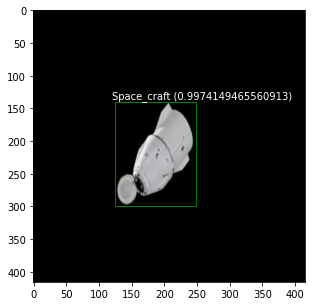

In [103]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.rcParams['text.color'] = 'white'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig, a = plt.subplots(1,1)
fig.set_size_inches(5,5)
a.imshow(img)
for (box, label, score) in zip(pred['boxes'], pred['labels'], pred['scores']):
    x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = patches.Rectangle((x, y),
                                width, height,
                                linewidth = 1,
                                edgecolor = 'g',
                                facecolor = 'none')

    s = class_list[label.cpu().numpy()] + ' ({})'.format(score.item())
    print(s)
    a.text(x-5, y-5, s)

    # Draw the bounding box on top of the image
    a.add_patch(rect)
plt.show()